In [18]:
%store -r g_junk

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')
sns.set(style="darkgrid" ,font_scale=1.8)

In [20]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [21]:
data = g_junk.drop(['App Name', 'Released'], axis=1).copy()

In [22]:
names = data.columns
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(data[['Size', 'Installs']])
data[['Size', 'Installs']] = scaled_d

Usiamo uno scaler differente per installs, perché il numero di installs ha una grande variabilità che non verrebbe apprezzata in uno scaling (0,1), empiricamente abbiamo visto che lo scaling (0,1e4) migliora le performance di logistic regression, e non è peggiorativo sugli altri modelli.

In [23]:
scaler = MinMaxScaler(feature_range=(0,1e4))
scaled_d = scaler.fit_transform(data[['Rating Count']])
data['Rating Count'] = scaled_d

In [24]:
data.Rating = data.Rating.apply(lambda x: round(x))
rating_0 = data[data.Rating == 0]
rating_1 = data[data.Rating == 1]
rating_2 = data[data.Rating == 2]
rating_3 = data[data.Rating == 3]
rating_4 = data[data.Rating == 4]
rating_5 = data[data.Rating == 5]
print("rating_0: ", len(rating_0), "rating_1: ", len(rating_1), " rating_2: ", len(rating_2), "rating_3: ", len(rating_3), "rating_4: ", len(rating_4), "rating_5: ", len(rating_5))

rating_0:  1038326 rating_1:  2930  rating_2:  38965 rating_3:  142860 rating_4:  677730 rating_5:  340870


In [25]:
myclasses = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1}
myclasses_t = {0:0, 1:0, 2:1, 3:1, 4:2, 5:2}
random_seed = 10

In [26]:
def reduce_to_one_class(series: pd.Series, cla: dict) -> pd.Series:
    return series.apply(lambda x: cla[x])

In [27]:
junk = pd.concat([rating_0, rating_1, rating_2])
junk.Rating = reduce_to_one_class(junk.Rating, myclasses)
top = pd.concat([rating_3, rating_4, rating_5])
top.Rating = reduce_to_one_class(top.Rating, myclasses)
balanced_b = pd.concat([junk, top.sample(len(junk), random_state=random_seed)])

In [28]:
junk_t = pd.concat([rating_0, rating_1])
junk_t.Rating = reduce_to_one_class(junk_t.Rating, myclasses_t)
middle_t = pd.concat([rating_2, rating_3])
middle_t.rating = reduce_to_one_class(middle_t.Rating, myclasses_t)
top_t = pd.concat([rating_4, rating_5])
top_t.Rating = reduce_to_one_class(top_t.Rating, myclasses_t)
balanced_t = pd.concat([pd.concat([top_t, junk_t.sample(len(top_t), random_state=random_seed)]).sample(len(middle_t), random_state=random_seed), middle_t])

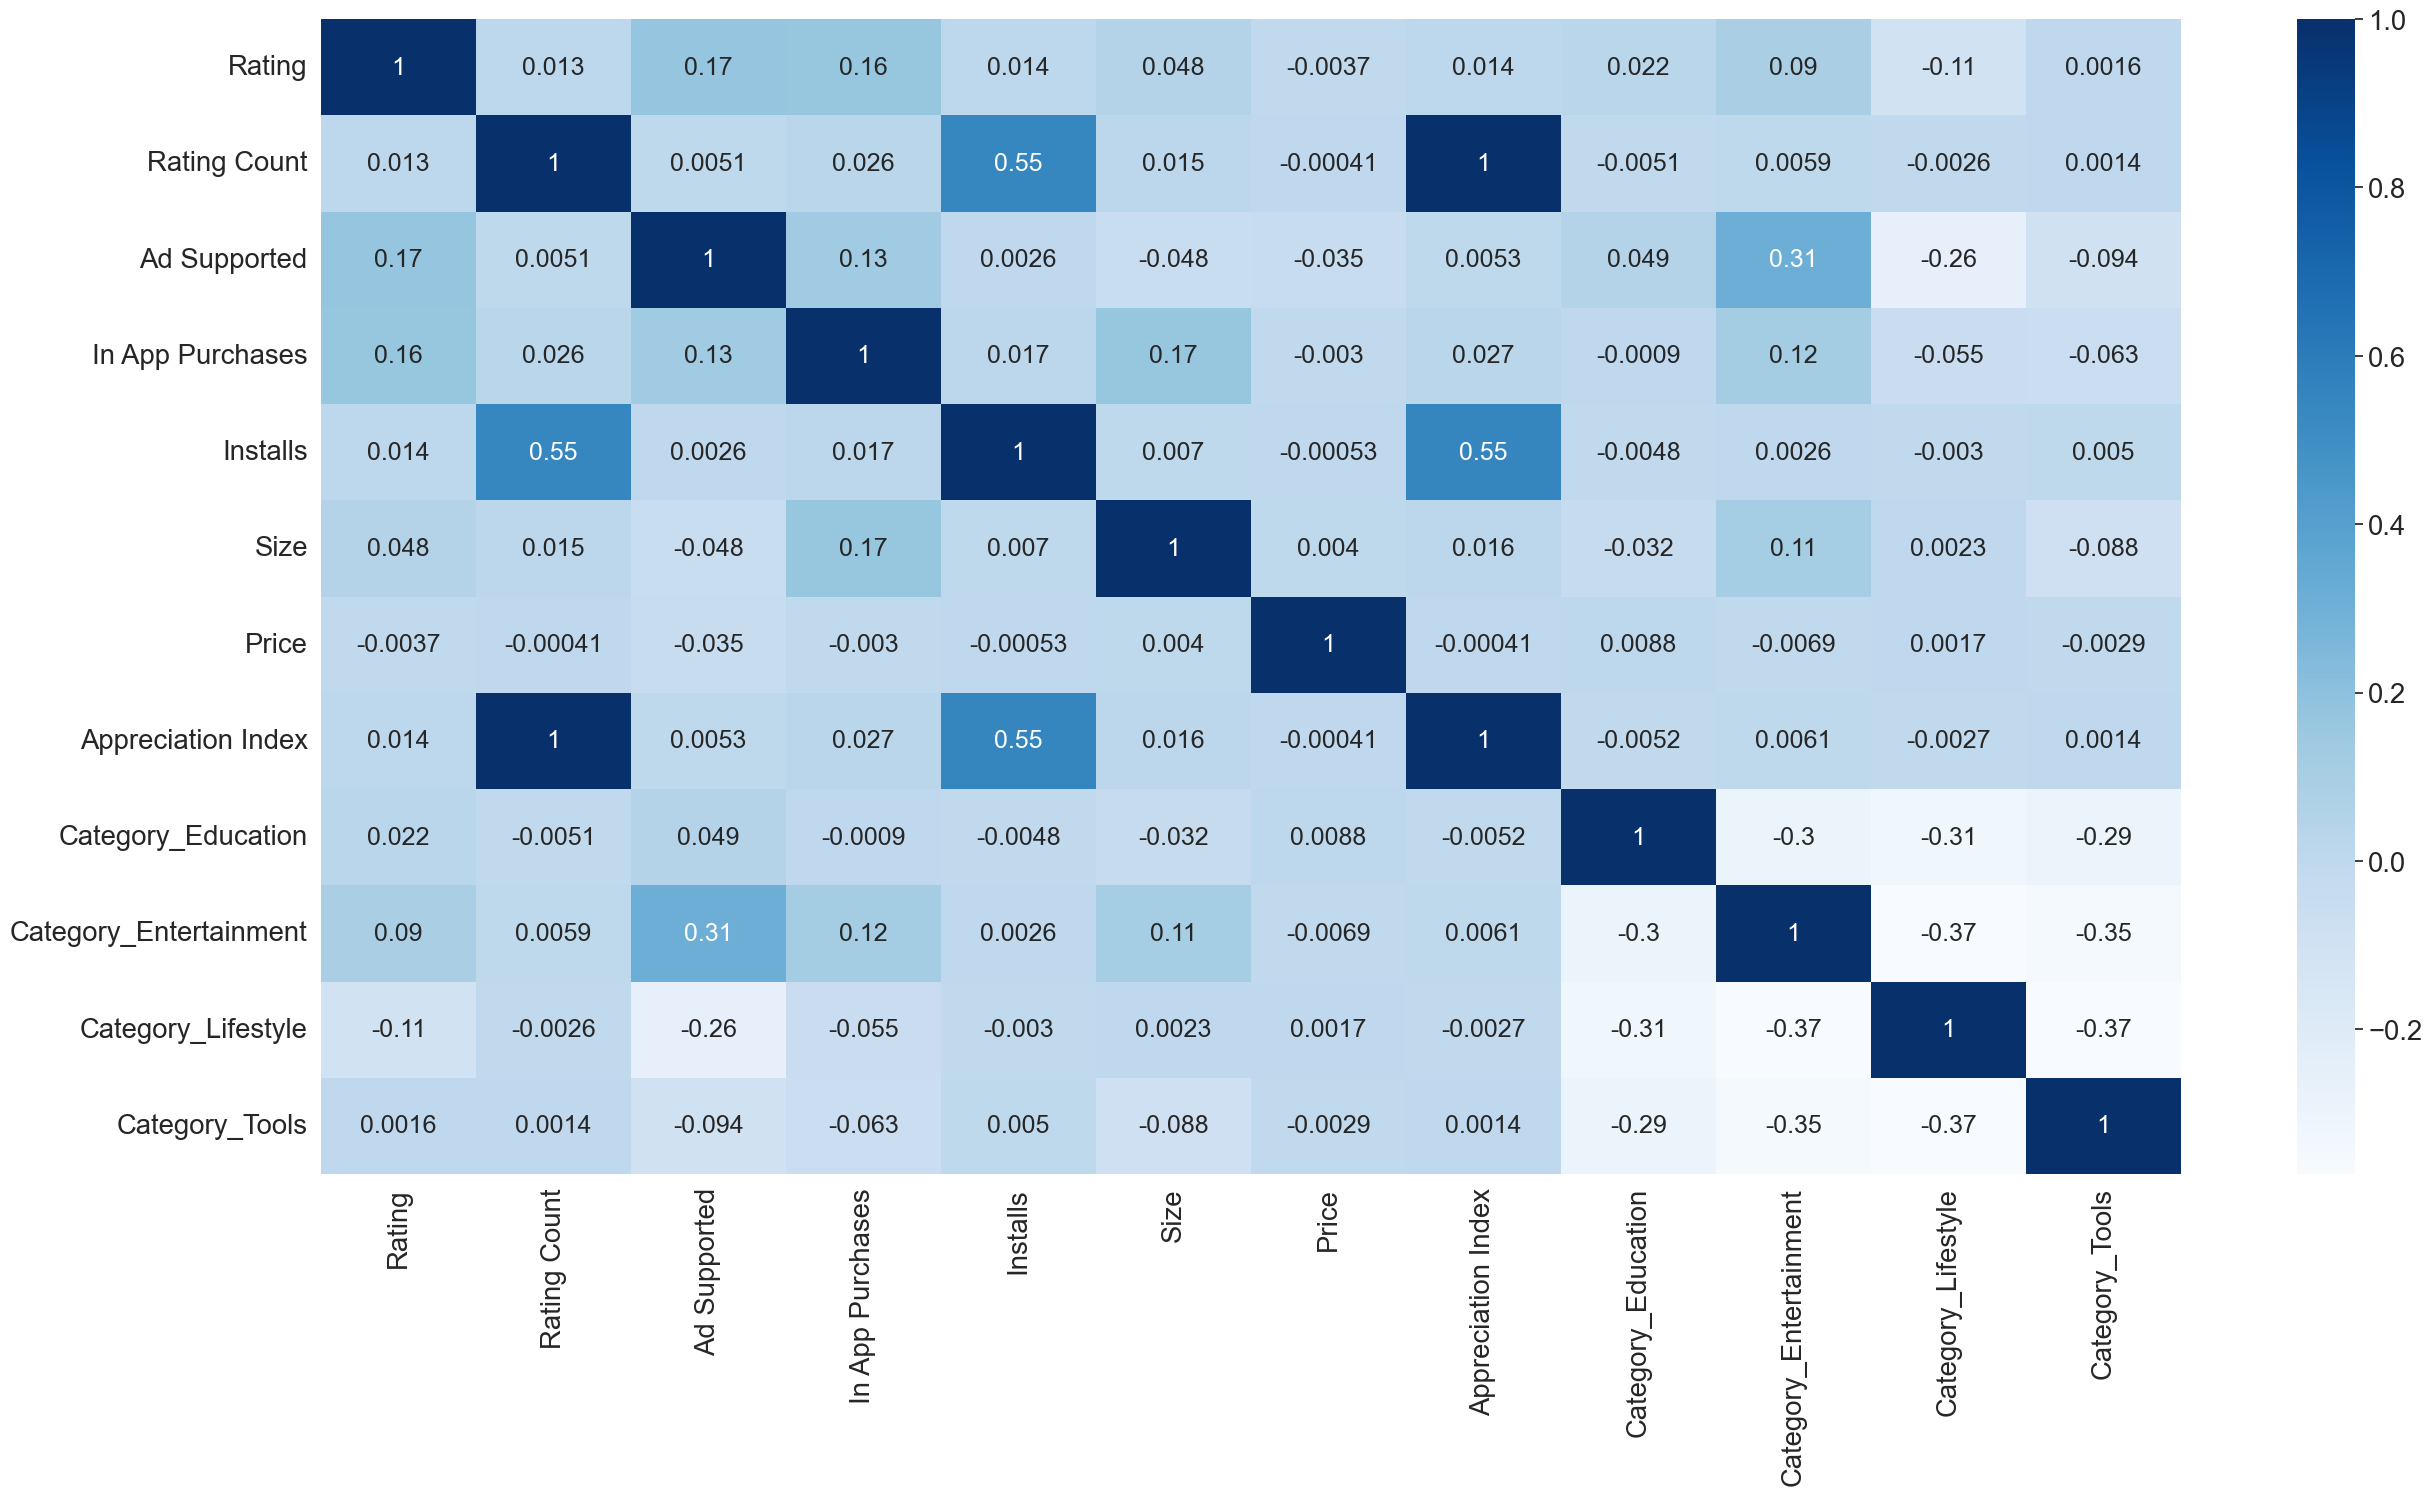

In [29]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(balanced_b[balanced_b.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [30]:
balanced_b.drop(['Installs', 'Appreciation Index'], axis=1, inplace=True)

In [31]:
balanced_t.drop(['Installs', 'Appreciation Index'], axis=1, inplace=True)

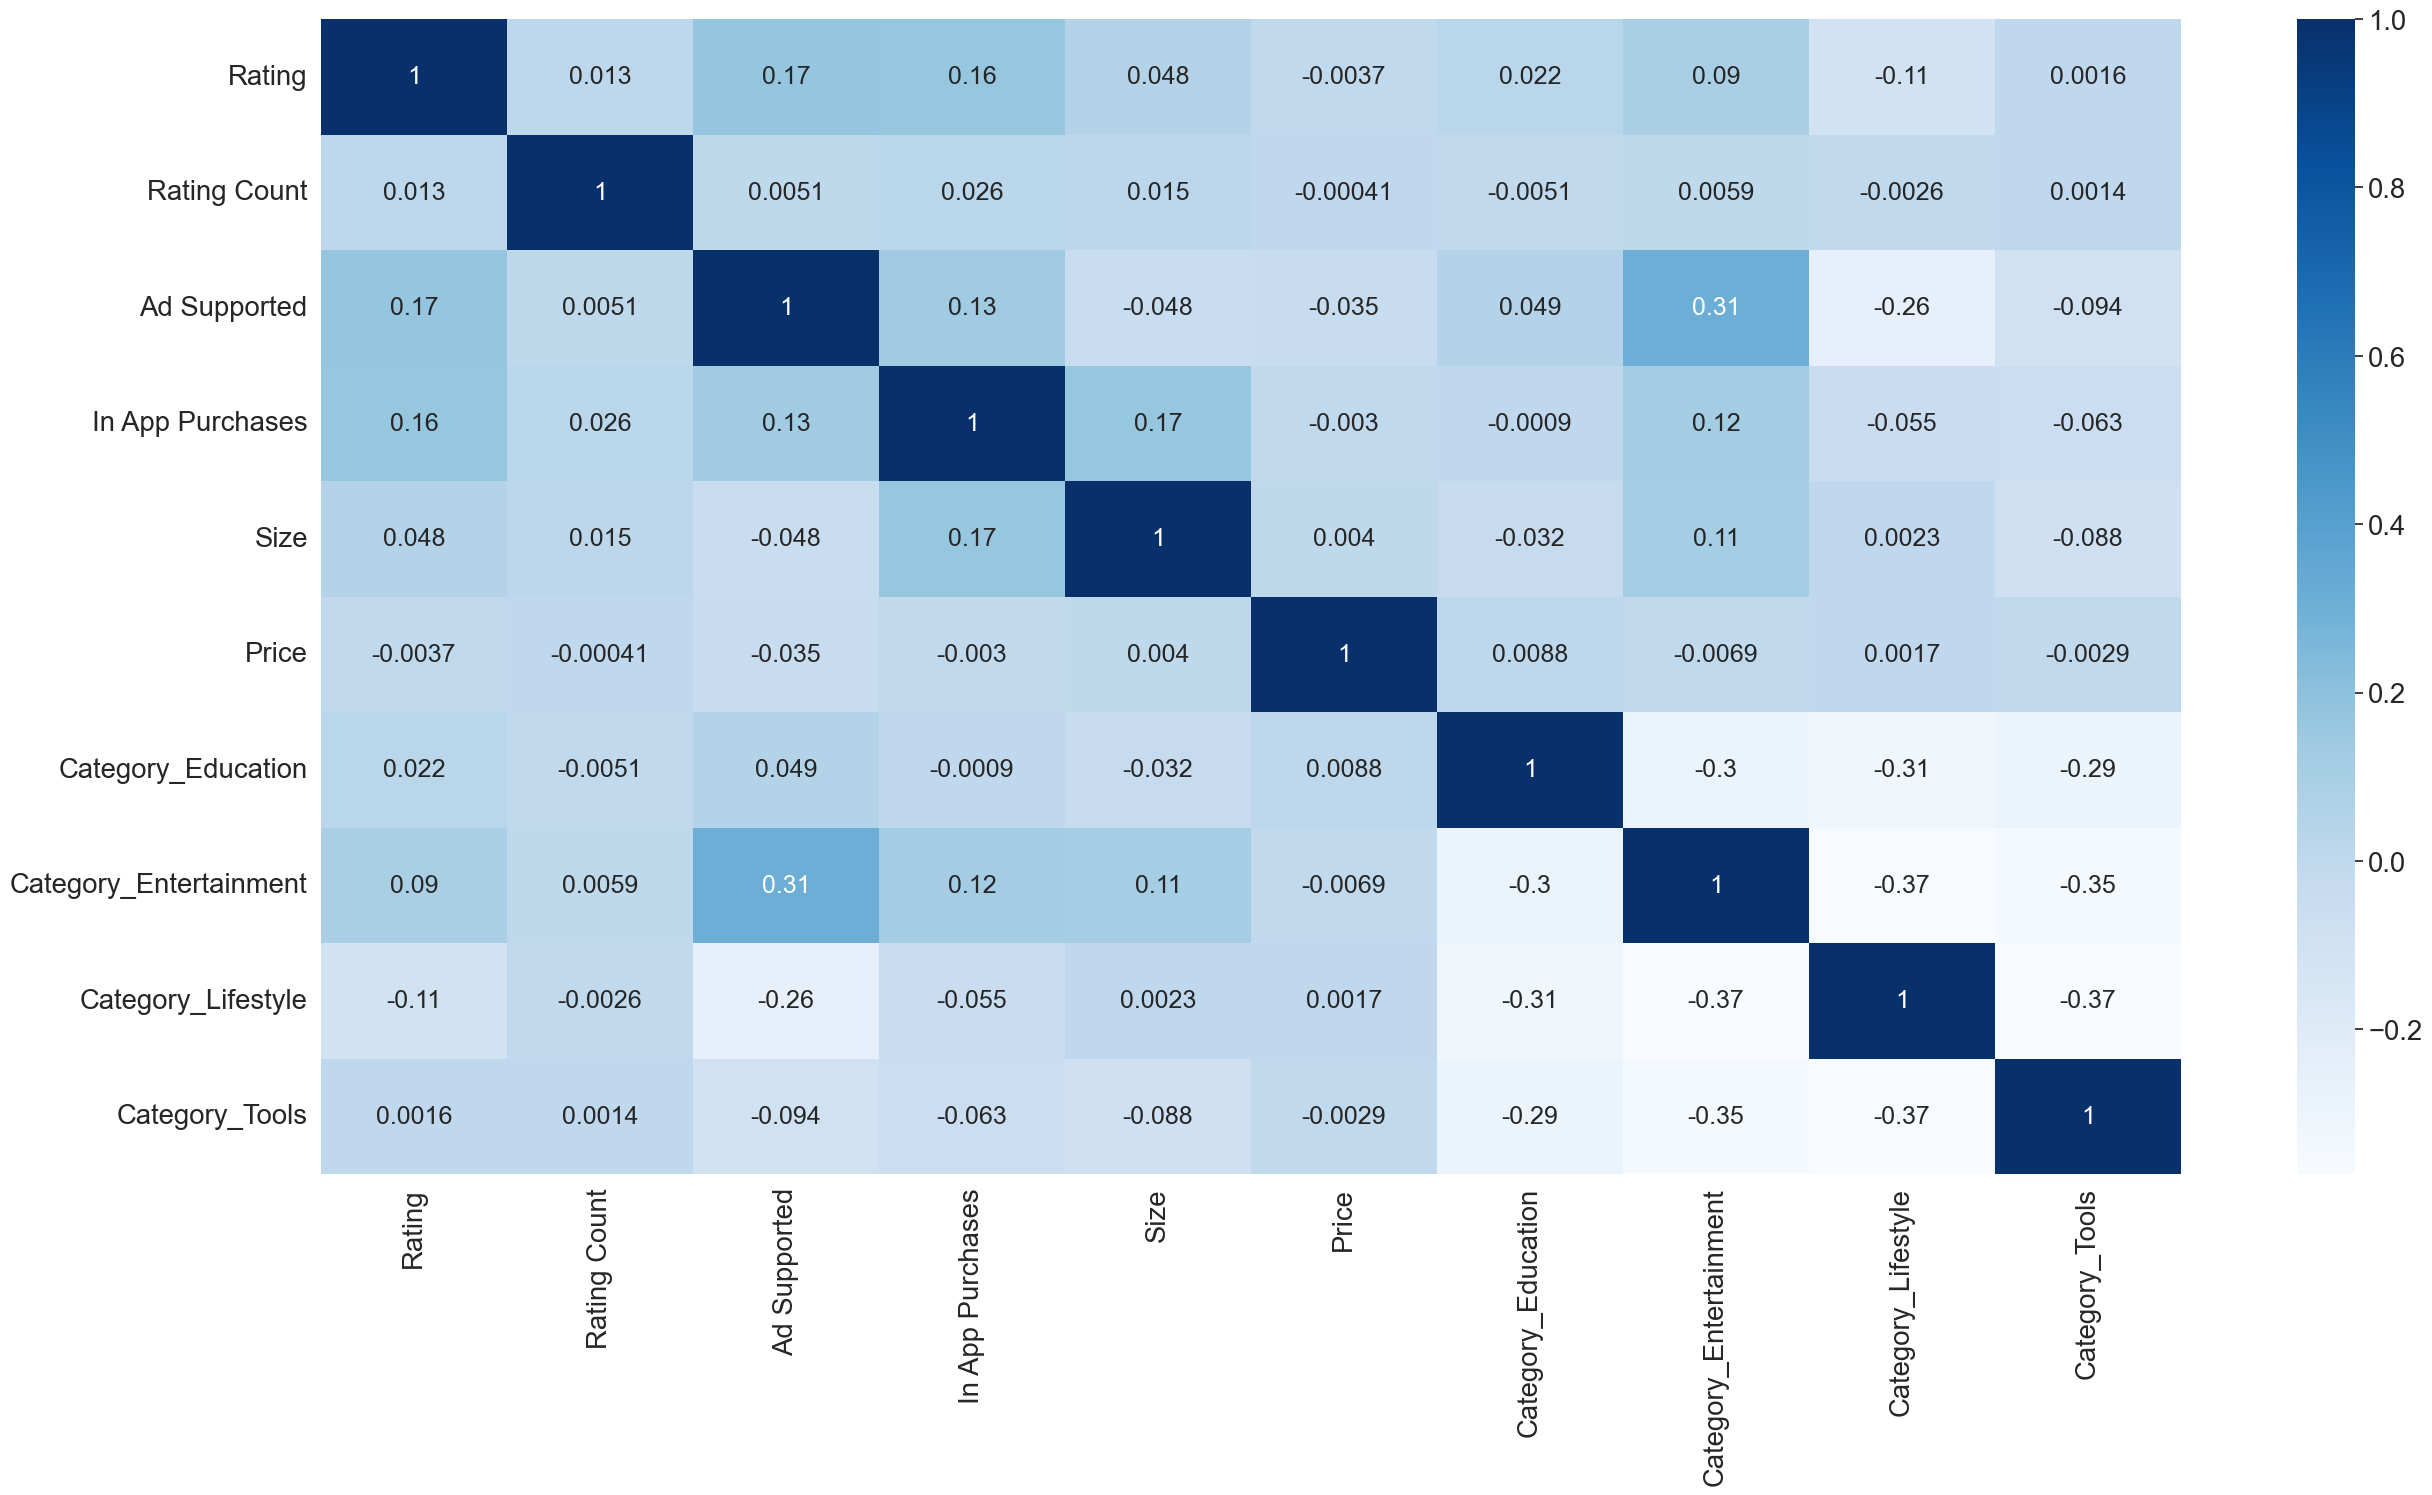

In [32]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(balanced_b[balanced_b.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [33]:
label = pd.get_dummies(balanced_b["Rating"], prefix = "rating") 
features = balanced_b.drop("Rating", axis=1)
rs = 1
train_features, test_features, train_labels, test_labels = train_test_split(features, label, test_size=0.1)

Multi-layer perceptron

In [34]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 20, 40, 6), max_iter=20,
validation_fraction=0.1, early_stopping=True, verbose=True, n_iter_no_change=10,
activation='relu', solver='adam', batch_size=32, momentum=0.9,
learning_rate='adaptive', random_state=rs)

mlp.fit(train_features.values, train_labels.rating_1.values)

Iteration 1, loss = 0.18341834
Validation score: 0.974671
Iteration 2, loss = 0.10002216
Validation score: 0.978775
Iteration 3, loss = 0.09517069
Validation score: 0.979428
Iteration 4, loss = 0.09371710
Validation score: 0.977139
Iteration 5, loss = 0.09285349
Validation score: 0.979310
Iteration 6, loss = 0.09203625
Validation score: 0.979505
Iteration 7, loss = 0.09256828
Validation score: 0.977139
Iteration 8, loss = 0.09159661
Validation score: 0.978960
Iteration 9, loss = 0.09117176
Validation score: 0.978862
Iteration 10, loss = 0.09027515
Validation score: 0.979001
Iteration 11, loss = 0.09041692
Validation score: 0.979073
Iteration 12, loss = 0.08965562
Validation score: 0.978770
Iteration 13, loss = 0.08878691
Validation score: 0.978960
Iteration 14, loss = 0.08818027
Validation score: 0.979330
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(batch_size=32, early_stopping=True,
              hidden_layer_sizes=(10, 20, 40, 6), learning_rate='adaptive',
              max_iter=20, random_state=1, verbose=True)

In [35]:
acc_during_train = mlp.score(train_features.values, train_labels.rating_1.values)
print('Accuratezza durante il training :', acc_during_train)
accuracy = mlp.score(test_features.values, test_labels.rating_1.values)
print(f'Accuratezza : {round(accuracy, 2)}   ---> {mlp.__class__.__name__}')

Accuratezza durante il training : 0.9804294081918455
Accuratezza : 0.98   ---> MLPClassifier


In [36]:
random_features = balanced_b.sample(n=100)
random_raw = pd.get_dummies(random_features["Rating"], prefix = "rating")
random_features.drop("Rating", axis=1, inplace=True)

In [37]:
pred = mlp.predict(test_features.values)

In [38]:
def check_pred(pred, givn):
    comp = list()
    for el in zip(pred, givn):
        if len(el) <= 2:
            if el[0] == el[1]:
                comp.append(True)
            else:
                comp.append(False)
        else :
            if all(el[0] == el[1]):
                comp.append(True)
            else :
                comp.append(False)
    comp = [el for el in zip(pred, givn, comp)]
    return comp

comp = check_pred(pred, test_labels.rating_1.values)

Altri classificatori

In [39]:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True, random_state=rs, max_iter=10),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
]

clf_name = [] 
model_results = pd.DataFrame.copy(test_labels)

kfold = StratifiedKFold(n_splits=5)
cv_results = [] 
cv_acc = []
cv_std = [] 
cnfm = []
clr = []
roc_auc = [] 
roc_tpr = []
roc_fpr = [] 

In [40]:
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    model = clf.fit(train_features, train_labels.rating_1)
    y_pred = model.predict(test_features)
    model_results[name] = y_pred
    
    cv_results.append(cross_val_score(clf, train_features, train_labels.rating_1, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(test_labels.rating_1, y_pred), 2)
    train_pred = clf.predict_proba(test_features)
    print(f'Accuracy: {acc} \t ---> {name} ')

    cnfm.append(confusion_matrix(test_labels.rating_1, y_pred))
    clr.append(classification_report(test_labels.rating_1, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, test_labels.rating_1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)

Accuracy: 0.75 	 ---> LogisticRegression 
Accuracy: 0.97 	 ---> DecisionTreeClassifier 
Accuracy: 0.5 	 ---> SVC 
Accuracy: 0.98 	 ---> KNeighborsClassifier 
Accuracy: 0.98 	 ---> RandomForestClassifier 


aggiungo ai risultati degli altri 4 modelli anche quelli del MLP

In [41]:
name = mlp.__class__.__name__
clf_name.append(name)
classifiers.append(mlp)
model_results[name] = pred
cv_results.append(cross_val_score(mlp, train_features, train_labels.rating_1, scoring = "accuracy",cv = kfold))
accuracy_rounded = round(accuracy, 2)
cnfm.append(confusion_matrix(test_labels.rating_1, pred))
clr.append(classification_report(test_labels.rating_1, pred))
fpr, tpr, thresholds = roc_curve(pred, test_labels.rating_1)
roc_auc.append(auc(fpr, tpr))
roc_tpr.append(tpr)
roc_fpr.append(fpr)

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Iteration 1, loss = 0.19858421
Validation score: 0.977345
Iteration 2, loss = 0.10476999
Validation score: 0.978322
Iteration 3, loss = 0.10068197
Validation score: 0.979949
Iteration 4, loss = 0.09838627
Validation score: 0.979460
Iteration 5, loss = 0.09713280
Validation score: 0.970891
Iteration 6, loss = 0.09643034
Validation score: 0.978412
Iteration 7, loss = 0.09358604
Validation score: 0.979364
Iteration 8, loss = 0.09083065
Validation score: 0.979981
Iteration 9, loss = 0.09001859
Validation score: 0.980367
Iteration 10, loss = 0.08988516
Validation score: 0.980026
Iteration 11, loss = 0.08951043
Validation score: 0.979647
Iteration 12, loss = 0.08991798
Validation score: 0.980245
Iteration 13, loss = 0.08997676
Validation score: 0.980129
Iteration 14, loss = 0.09002539
Validation score: 0.979068
Iteration 15, loss = 0.08961682
Validation score: 0.979679
Iteration 16, loss = 0.08953733
Validation score: 0.980000
Iteration 17, loss = 0.08902446
Validation score: 0.978001
Iterat

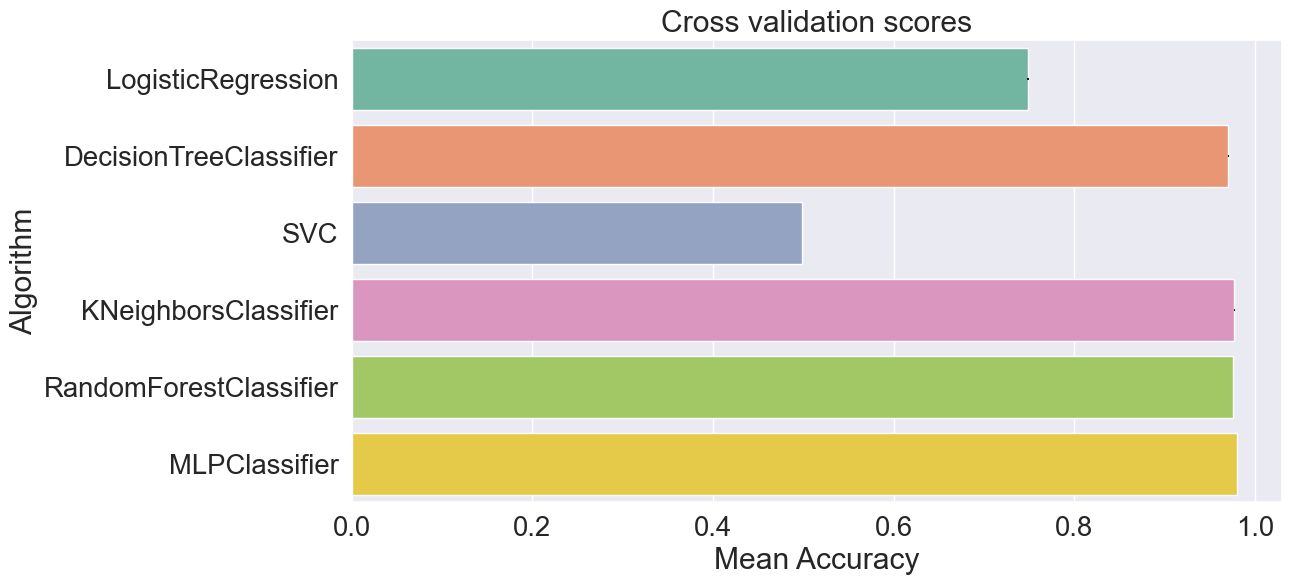

In [54]:
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans", y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")
plt.show()

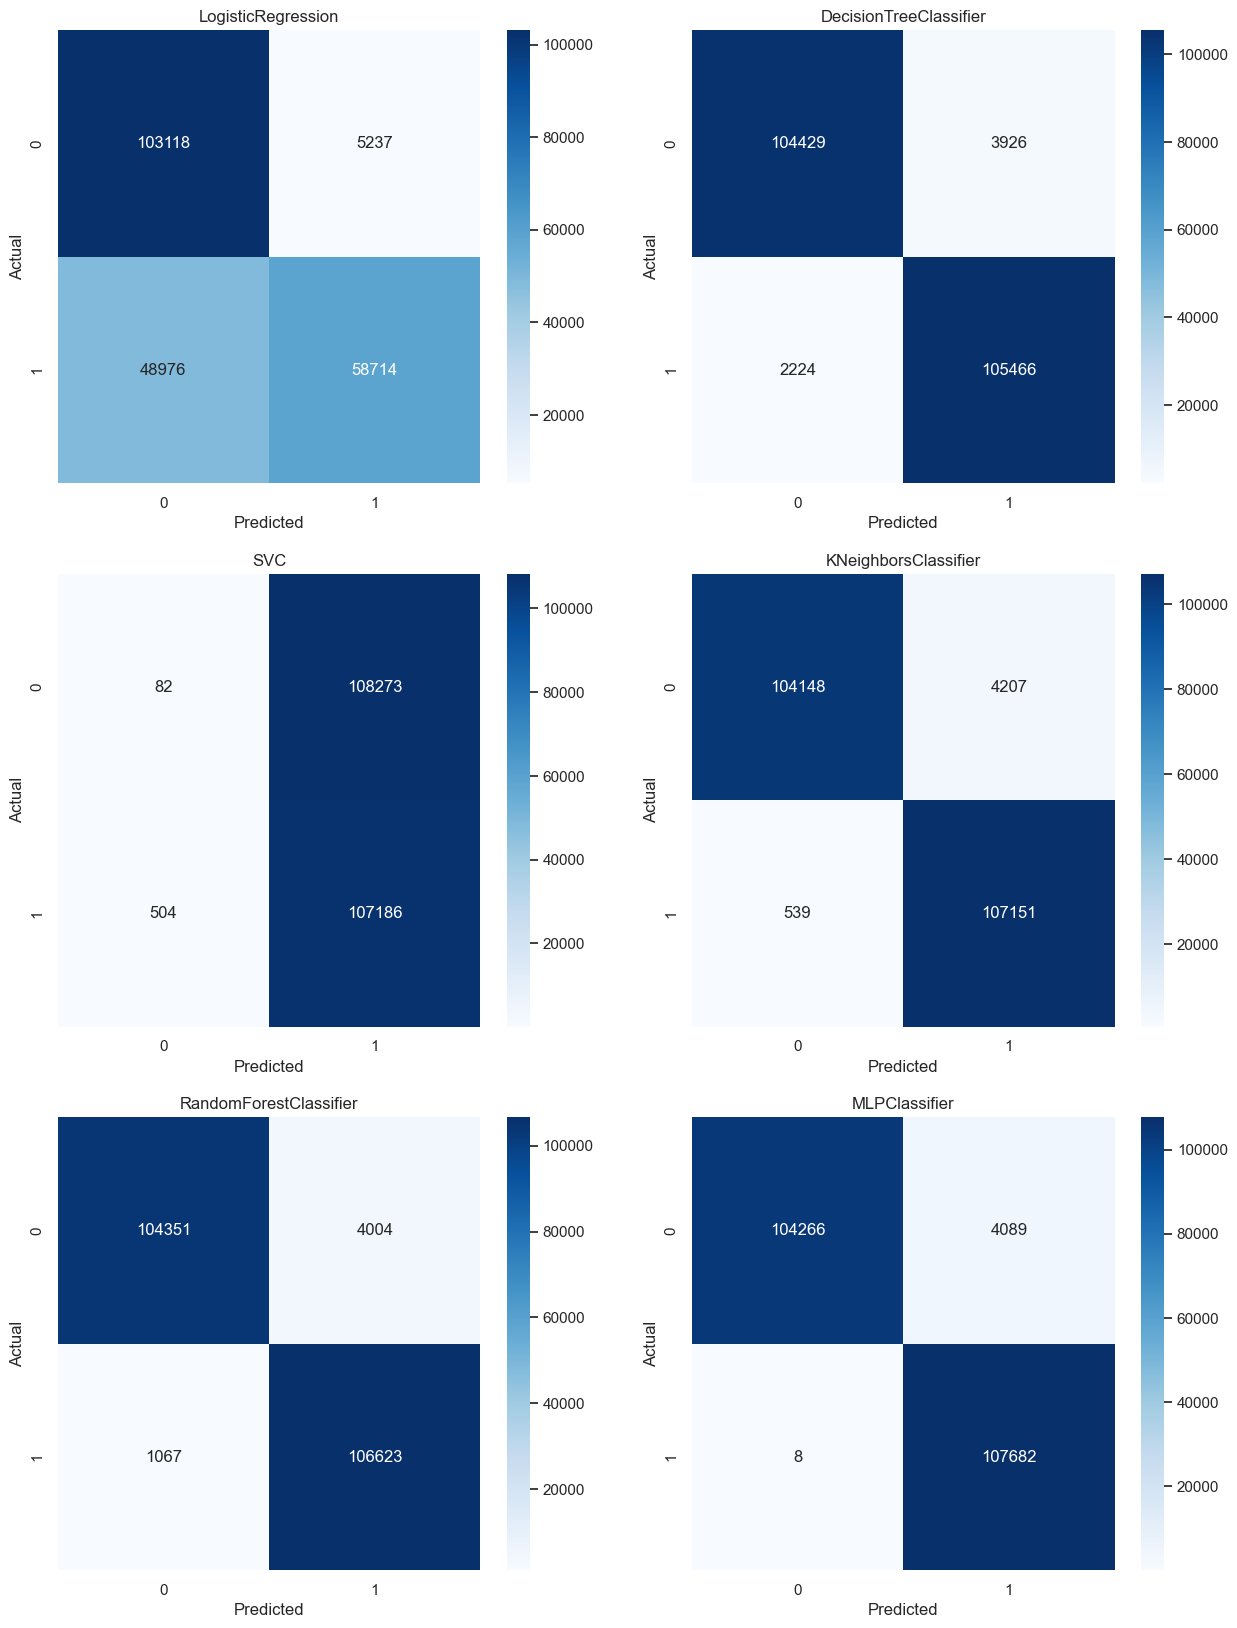

In [55]:
plt.figure(figsize=(15,20))
sns.set(font_scale=1)
for i in range(len(classifiers)):
    plt.subplot(3,2,i+1)
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])
plt.show()

In [56]:
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);

LogisticRegression Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.95      0.79    108355
        True       0.92      0.55      0.68    107690

    accuracy                           0.75    216045
   macro avg       0.80      0.75      0.74    216045
weighted avg       0.80      0.75      0.74    216045

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.96      0.97    108355
        True       0.96      0.98      0.97    107690

    accuracy                           0.97    216045
   macro avg       0.97      0.97      0.97    216045
weighted avg       0.97      0.97      0.97    216045

SVC Classification Report:
              precision    recall  f1-score   support

       False       0.14      0.00      0.00    108355
        True       0.50      1.00      0.66    107690

    accuracy                           0.50    216045
   macro avg 

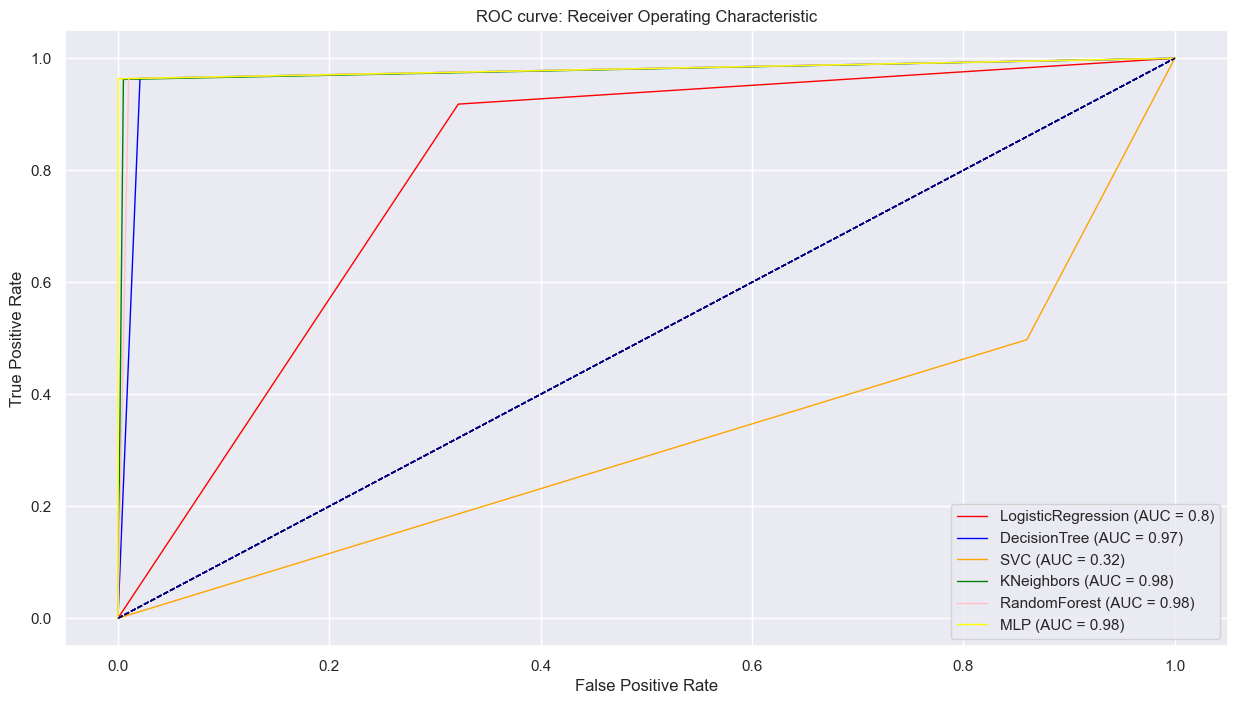

In [57]:
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue']
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")
plt.show()

Classificazione ternaria

In [58]:
label_t = pd.get_dummies(balanced_t["Rating"], prefix = "rating") 
features_t = balanced_t.drop("Rating", axis=1)
rs = 1
train_features_t, test_features_t, train_labels_t, test_labels_t = train_test_split(features_t, label_t, test_size=0.1)

In [59]:
mlp_t = MLPClassifier(hidden_layer_sizes=(10, 20, 40, 6), max_iter=20,
validation_fraction=0.1, early_stopping=True, verbose=True, n_iter_no_change=10,
activation='relu', solver='adam', batch_size=32, momentum=0.9,
learning_rate='adaptive', random_state=rs)

mlp_t.fit(train_features_t, train_labels_t)

Iteration 1, loss = 1.62425828
Validation score: 0.505973
Iteration 2, loss = 1.14355165
Validation score: 0.598399
Iteration 3, loss = 1.10716000
Validation score: 0.592044
Iteration 4, loss = 1.09593997
Validation score: 0.597116
Iteration 5, loss = 1.09304688
Validation score: 0.625592
Iteration 6, loss = 1.08112859
Validation score: 0.623637
Iteration 7, loss = 1.07419490
Validation score: 0.608207
Iteration 8, loss = 1.06839746
Validation score: 0.645635
Iteration 9, loss = 1.06314658
Validation score: 0.647071
Iteration 10, loss = 1.06087029
Validation score: 0.633811
Iteration 11, loss = 1.06559059
Validation score: 0.637355
Iteration 12, loss = 1.05824095
Validation score: 0.650005
Iteration 13, loss = 1.06111351
Validation score: 0.642824
Iteration 14, loss = 1.05611912
Validation score: 0.646980
Iteration 15, loss = 1.06003518
Validation score: 0.647835
Iteration 16, loss = 1.05473049
Validation score: 0.609032
Iteration 17, loss = 1.05397204
Validation score: 0.647102
Iterat

MLPClassifier(batch_size=32, early_stopping=True,
              hidden_layer_sizes=(10, 20, 40, 6), learning_rate='adaptive',
              max_iter=20, random_state=1, verbose=True)

In [60]:
acc_during_train_t = mlp_t.score(train_features_t, train_labels_t)
print('Accuratezza durante il training :', acc_during_train_t)
accuracy_t = mlp_t.score(test_features_t, test_labels_t)
print(f'Accuratezza : {round(accuracy_t, 2)}   ---> {mlp_t.__class__.__name__}')

Accuratezza durante il training : 0.6543593504132484
Accuratezza : 0.66   ---> MLPClassifier


In [61]:
pred_t = mlp_t.predict(test_features_t)

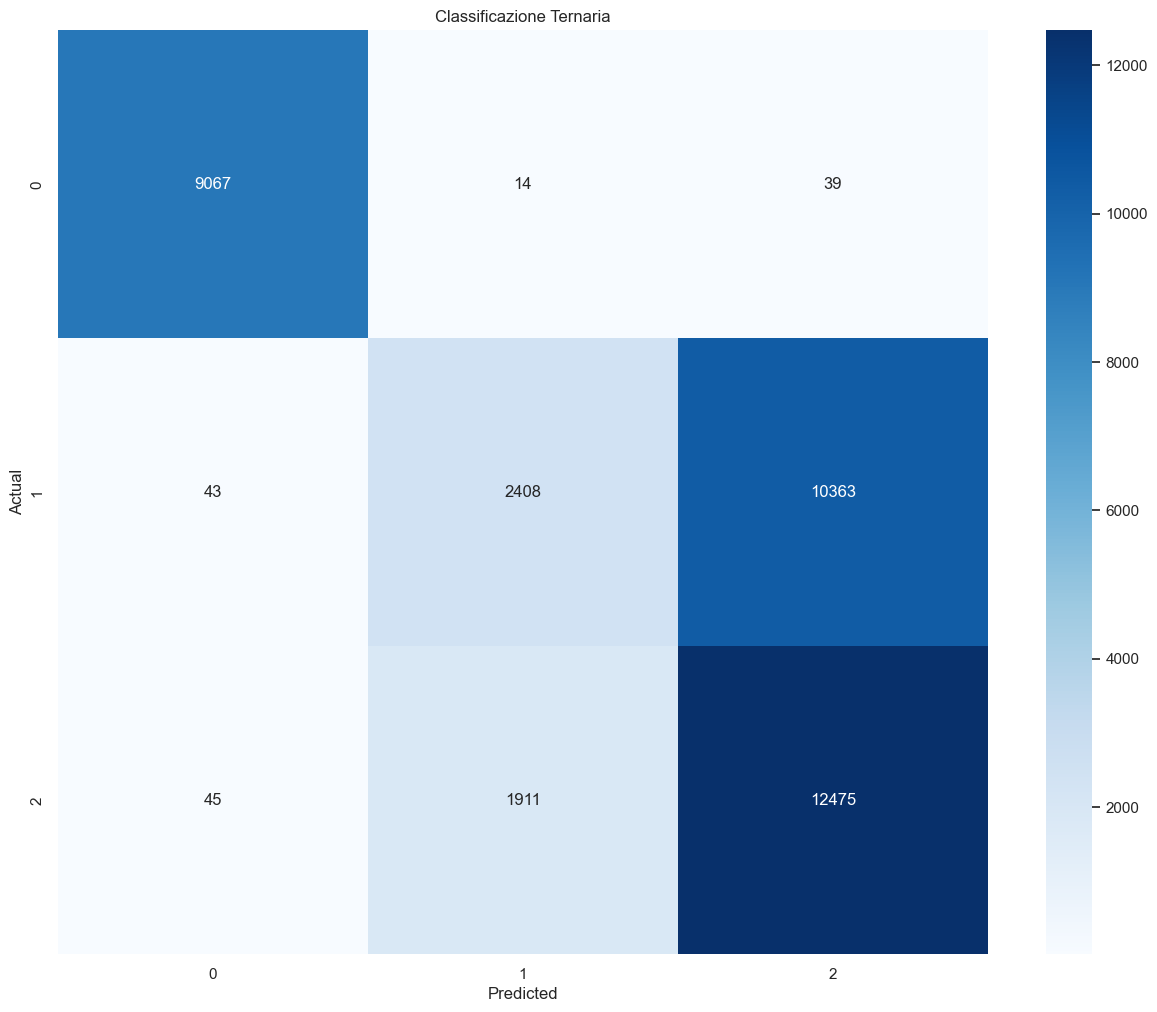

In [62]:
plt.figure(figsize=(15,12))
sns.set(font_scale=1)
c_matrix = confusion_matrix(test_labels_t.values.argmax(axis=1), pred_t.argmax(axis=1))
sns.heatmap(c_matrix, annot=True, fmt="d",cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classificazione Ternaria')
plt.show()

In [77]:
classifiers = {
    'mlp' : MLPClassifier(hidden_layer_sizes=(10, 20, 40, 6), max_iter=20,
    validation_fraction=0.1, early_stopping=True, verbose=True, n_iter_no_change=10,
    activation='relu', solver='adam', batch_size=32, momentum=0.9,
    learning_rate='adaptive', random_state=rs),
    'kneighbors' : KNeighborsClassifier(),
    'random_forest': RandomForestClassifier(n_estimators = 10, random_state=rs),
}

Addestramento di insieme

In [119]:
def combine_predictions(predictions):
    # Converti le previsioni in array booleani
    for label, preds in predictions.items():
        predictions[label] = np.array(preds)

    # Calcola il numero di voti per ciascuna riga
    num_votes = np.sum(list(predictions.values()), axis=0)
    combined = np.zeros_like(num_votes, dtype=int)
    combined[np.arange(num_votes.shape[0]), num_votes.argmax(axis=1)] = 1

    return combined

In [116]:
def ensemble_classification(train_features, train_labels, test_features, test_labels, models, mode='hard'):
    """
    Effettua ensemble classification con modalità 'hard' o 'soft'.

    Parameters:
    - train_features: DataFrame, le feature del training set
    - train_labels: DataFrame, le etichette del training set
    - test_features: DataFrame, le feature del test set
    - test_labels: DataFrame, le etichette del test set
    - models: dict, dizionario di modelli, chiavi sono i nomi dei modelli
    - mode: str, 'hard' per il voto maggioritario, 'soft' per il voto pesato

    Returns:
    - accuracy: float, l'accuratezza delle previsioni
    """

    # Crea una copia dei modelli per ciascuna colonna
    cloned_models = {label: clone(model) for label, model in models.items()}

    # Addestra i modelli separati per ciascuna colonna
    for label, model in cloned_models.items():
        model.fit(train_features, train_labels)

    # Effettua predizioni sul set di test
    predictions = {label: model.predict(test_features) for label, model in cloned_models.items()}
    # Combina le previsioni
    combined_predictions = []
    if mode == 'hard':
        combined_predictions = combine_predictions(predictions)
    accuracy = accuracy_score(np.array(test_labels), np.array(combined_predictions))
    print(f"Accuracy ({mode} mode): {accuracy}")

    return accuracy

In [120]:
accuracy = ensemble_classification(train_features_t, train_labels_t, test_features_t, test_labels_t, classifiers, mode='hard')

Iteration 1, loss = 1.62425828
Validation score: 0.505973
Iteration 2, loss = 1.14355165
Validation score: 0.598399
Iteration 3, loss = 1.10716000
Validation score: 0.592044
Iteration 4, loss = 1.09593997
Validation score: 0.597116
Iteration 5, loss = 1.09304688
Validation score: 0.625592
Iteration 6, loss = 1.08112859
Validation score: 0.623637
Iteration 7, loss = 1.07419490
Validation score: 0.608207
Iteration 8, loss = 1.06839746
Validation score: 0.645635
Iteration 9, loss = 1.06314658
Validation score: 0.647071
Iteration 10, loss = 1.06087029
Validation score: 0.633811
Iteration 11, loss = 1.06559059
Validation score: 0.637355
Iteration 12, loss = 1.05824095
Validation score: 0.650005
Iteration 13, loss = 1.06111351
Validation score: 0.642824
Iteration 14, loss = 1.05611912
Validation score: 0.646980
Iteration 15, loss = 1.06003518
Validation score: 0.647835
Iteration 16, loss = 1.05473049
Validation score: 0.609032
Iteration 17, loss = 1.05397204
Validation score: 0.647102
Iterat

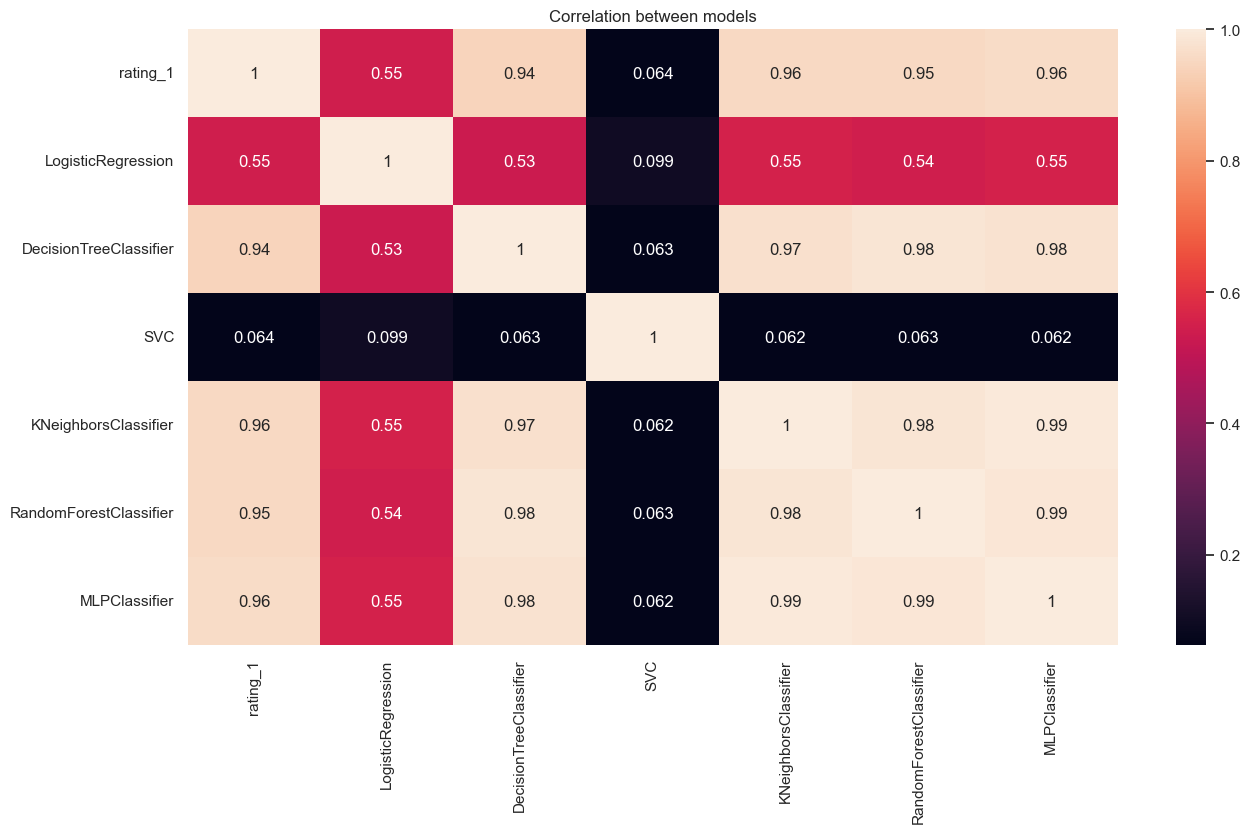

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop('rating_0', axis=1).corr(),annot=True)
plt.title('Correlation between models')
plt.show()

Testare il modello

In [ ]:
best_model = mlp #VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1])], voting='soft', n_jobs=4)
best_model.fit(train_features,train_labels.rating_1)
print(accuracy_score(test_labels.rating_1,best_model.predict(test_features)))

Iteration 1, loss = 0.18043690
Validation score: 0.974861
Iteration 2, loss = 0.10010427
Validation score: 0.978976
Iteration 3, loss = 0.09685550
Validation score: 0.979814
Iteration 4, loss = 0.09399207
Validation score: 0.979634
Iteration 5, loss = 0.09202924
Validation score: 0.979557
Iteration 6, loss = 0.09278976
Validation score: 0.979896
Iteration 7, loss = 0.09207105
Validation score: 0.979613
Iteration 8, loss = 0.09123847
Validation score: 0.979855
Iteration 9, loss = 0.09179292
Validation score: 0.979408
Iteration 10, loss = 0.09168891
Validation score: 0.978718
Iteration 11, loss = 0.09032080
Validation score: 0.979629
Iteration 12, loss = 0.08971218
Validation score: 0.978888
Iteration 13, loss = 0.08982609
Validation score: 0.961988
Iteration 14, loss = 0.08867826
Validation score: 0.979948
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.980096739105279


In [ ]:
rating = pd.Series(best_model.predict(g_junk.drop(['App Name', 'Rating', 'Installs', 'Appreciation Index', 'Released'], axis=1)), name='Rating')

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

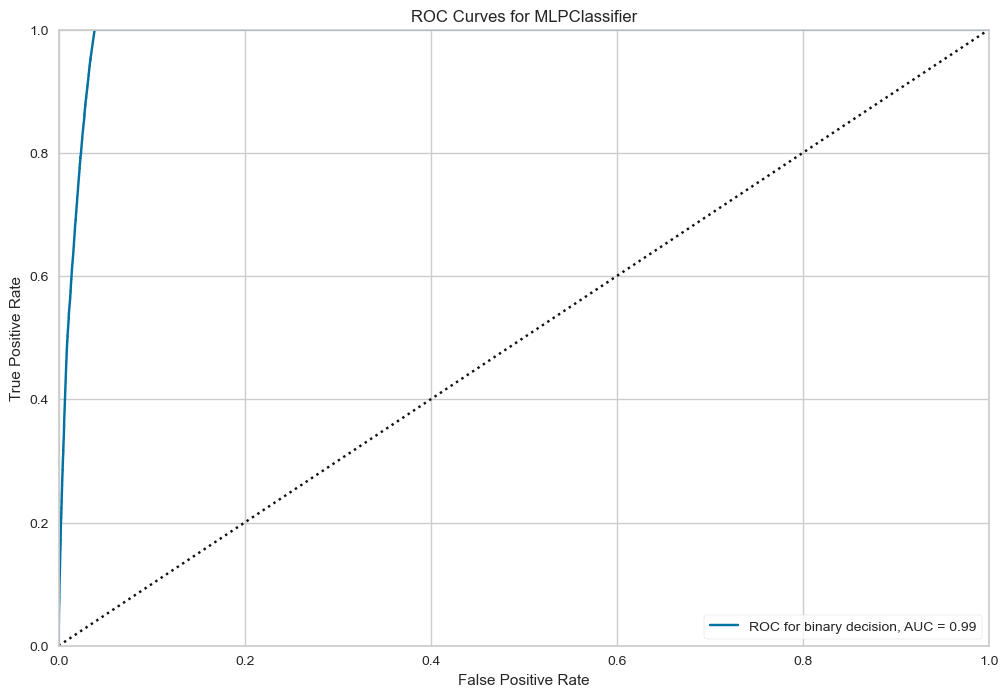

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=['low rated', 'high rated'], micro=False, macro=False, binary=True)
visualizer.fit(train_features, train_labels.rating_1)        
visualizer.score(test_features, test_labels.rating_1)        
visualizer.show()                       

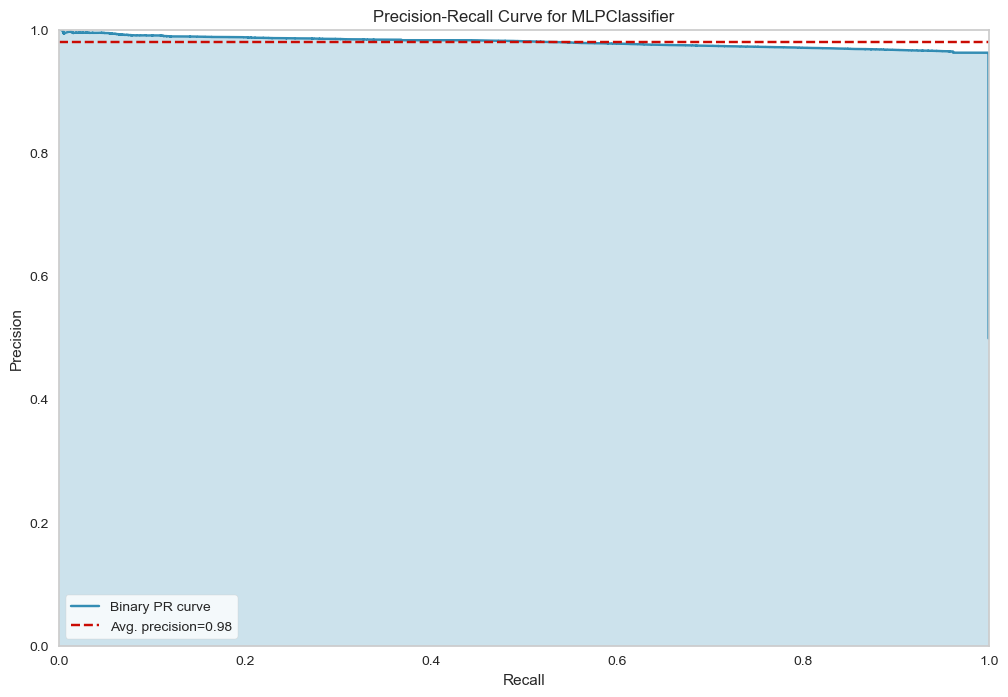

<AxesSubplot:title={'center':'Precision-Recall Curve for MLPClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
plt.figure(figsize=(12,8))
viz = PrecisionRecallCurve(best_model)
viz.fit(train_features, train_labels.rating_1)
viz.score(test_features, test_labels.rating_1)
viz.show()

In [ ]:
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(train_features,train_labels.rating_1)
visualizer.show()